# Sentiment Analysis Model Training with Spark MLlib
This notebook focuses on training a sentiment analysis model using the Sentiment140 dataset, which contains 1.6 million tweets labeled as positive or negative sentiment.

## 1. Import Required Libraries and Initialize Spark


In [36]:
import os
import time
import re
import string
from datetime import datetime

import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay


from pyspark.sql import SparkSession
from pyspark.sql import SQLContext  
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql import functions as F

from pyspark.ml  import Pipeline    
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [6]:
# initialize a spark Session
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("Twitter Sentiments Analysis") \
    .getOrCreate()

spark

In [33]:
spark.sparkContext.setLogLevel("INFO")


## 2. Load the Dataset

In [7]:
# define the dataset schema
schema = StructType([
    StructField("target", StringType(), True),
    StructField("ids", StringType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)])

# Read the data from hdfs
dataset_path = "hdfs://namenode:9000/user/data/tweets.csv"

df = spark.read.csv(dataset_path, header=False, schema=schema)
df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|target|       ids|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     0|1467811795|Mon Apr 06 22:20:...|NO_

In [8]:
df.printSchema()

root
 |-- target: string (nullable = true)
 |-- ids: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [9]:
df.select("target").distinct().show()

+------+
|target|
+------+
|     4|
|     0|
+------+



In [10]:
df.groupby("target").count().show()

+------+------+
|target| count|
+------+------+
|     0|800000|
|     4|800000|
+------+------+



In [11]:
df = df.dropna()
df.count()

1600000

In [13]:
# Sample positive tweets
print("Positive Tweets:")
df.filter(F.col("target") == 4).select("text").show(5, truncate=False)

Positive Tweets:
+-----------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                     |
+-----------------------------------------------------------------------------------------------------------------------------------------+
|I LOVE @Health4UandPets u guys r the best!!                                                                                              |
|im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!                                                                 |
|@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. |
|Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup                                 |
|@L

In [14]:

# Sample negative tweets
print("Negative Tweets:")
df.filter(F.col("target") == 0).select("text").show(5, truncate=False)

Negative Tweets:
+-------------------------------------------------------------------------------------------------------------------+
|text                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          |
|my whole body feels itchy and like its on fire                                                                     |
|@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     |
+--------------------------------------

In [18]:
def preprocessing(sparkDF,col):
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, r'http\S+', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, '@\w+', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, '#', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, 'RT', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, ':', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, '[^A-Za-z0-9]+', ' '))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, '\-', ''))
    sparkDF = sparkDF.withColumn(col, F.regexp_replace(col, '[ ]+', ' '))
    sparkDF = sparkDF.withColumn(col, F.trim(sparkDF[col]))

    return sparkDF

In [19]:
df = preprocessing(df,'text')

In [20]:
df.show(25)

+------+----------+--------------------+--------+---------------+--------------------+
|target|       ids|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|Awww that s a bum...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|I dived many time...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|no it s not behav...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|  not the whole crew|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|          Need a hug|
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|hey long time no ...|
|     0|1467811795|Mon Apr 06 22:20:...|NO_

In [21]:
df.groupBy('user').count().sort('count',ascending=False).show(10)

+---------------+-----+
|           user|count|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
+---------------+-----+
only showing top 10 rows



In [26]:
(train_set, test_set) = df.randomSplit([0.80, 0.20], seed = 42)
print(f"Training Data Count: {train_set.count()}")
print(f"Test Data Count: {test_set.count()}")

Training Data Count: 1280507
Test Data Count: 319493


## Logistic Regression
### HashingTF - IDF

In [31]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashtf = HashingTF(inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, lr])

In [32]:
%%time

st = datetime.utcnow()
pipelineFit = pipeline.fit(train_set)
print('Training time:', datetime.utcnow() - st)

Training time: 0:01:48.823083
CPU times: user 30 ms, sys: 11.8 ms, total: 41.8 ms
Wall time: 1min 48s


In [37]:
predictions = pipelineFit.transform(test_set)


evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7728275736870605
Precision: 0.7729309262617718
Recall: 0.7728275736870605


### HashingTF - IDF (Custom Parameters)

In [38]:
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, lr])

In [39]:
%%time
st = datetime.utcnow()

pipelineFit = pipeline.fit(train_set)
print('Training time:', datetime.utcnow() - st)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Training time: 0:01:46.035668
Accuracy: 0.7879546656734263
Precision: 0.7881510044749059
Recall: 0.7879546656734263
CPU times: user 105 ms, sys: 35.9 ms, total: 141 ms
Wall time: 2min 45s


### CountVectorizer - IDF

In [42]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

In [43]:
%%time
st = datetime.utcnow()

pipelineFit = pipeline.fit(train_set)
print('Training time:', datetime.utcnow() - st)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Training time: 0:02:20.834556
Accuracy: 0.7769841592773551
Precision: 0.7770910297992351
Recall: 0.7769841592773551
CPU times: user 53.3 ms, sys: 23.2 ms, total: 76.5 ms
Wall time: 3min 16s


### CountVectorizer - IDF (Custom Parameters)

In [44]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

In [45]:
%%time
st = datetime.utcnow()

pipelineFit = pipeline.fit(train_set)
print('Training time:', datetime.utcnow() - st)

Training time: 0:01:52.191382
CPU times: user 46.2 ms, sys: 12.2 ms, total: 58.4 ms
Wall time: 1min 52s


In [ ]:
predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

### Grid Search

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0, 10.0]) \
    .addGrid(lr.maxIter, [20, 50, 100, 500, 1000]) \
    .addGrid(lr.elasticNetParam, [0, 0.5, 1.0]) \
    .build()

cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

In [ ]:
%%time
pipelineFit = cv.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

bestModel = pipelineFit.bestModel
pipelineFit.getEstimatorParamMaps()[np.argmax(pipelineFit.avgMetrics)]

In [48]:
def build_trigrams(inputCol=["text","target"], n=3):
    
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    
    lr = [LogisticRegression(regParam = 0.1, maxIter = 1000, elasticNetParam = 0.0)]
    
    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + lr)

In [49]:
start = time.time()

pipelineFit = build_trigrams().fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

end = time.time()
print(end - start)

Accuracy: 0.8083025293198912
Precision: 0.8095422976729054
Recall: 0.8083025293198912
491.3589754104614


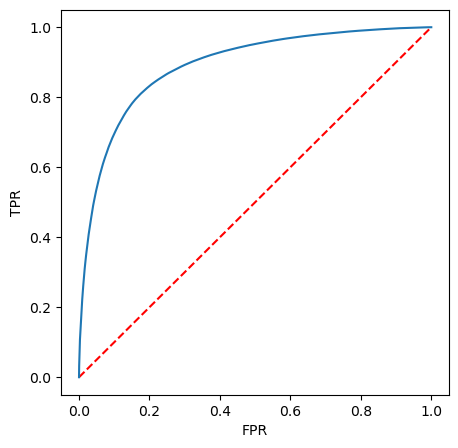

In [50]:
plt.figure(figsize=(5,5))

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(pipelineFit.stages[-1].summary.roc.select('FPR').collect(),
         pipelineFit.stages[-1].summary.roc.select('TPR').collect())

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

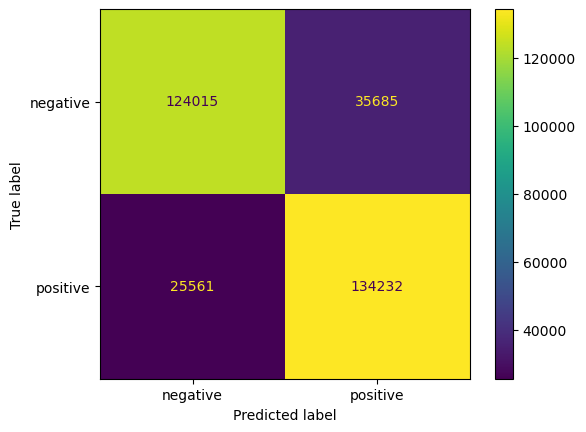

In [52]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

In [55]:
# Define the model name
model_name = "logistic_regression"  # Example: name for logistic regression
# Define the path to save the best model, including the model name in the path
model_save_path = f"hdfs://namenode:9000/models/{model_name}"

# Save the model
pipelineFit.save(model_save_path)

print(f"Best model saved at: {model_save_path}")

Best model saved at: hdfs://namenode:9000/models/logistic_regression
